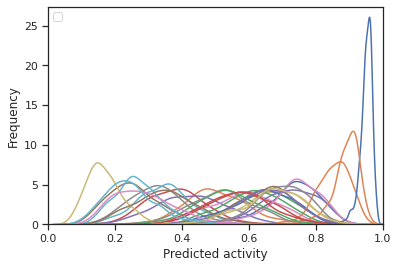

In [37]:
# Plot the first 30 prediction distributions

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 1, "ytick.major.size": 1})

preds = pd.read_csv('CYP_1a2_0.4_predicted_ys.csv')

for x in range(30):
    sns.kdeplot(preds[str(x)])

plt.xlim([0,1])   
plt.ylabel('Frequency')
plt.xlabel('Predicted activity')
plt.legend('')
plt.show()

plotting mean...


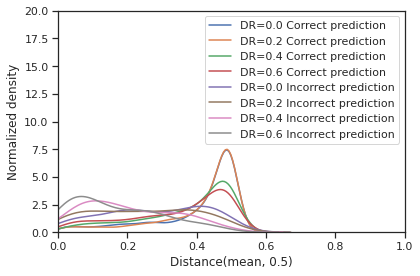

plotting std...


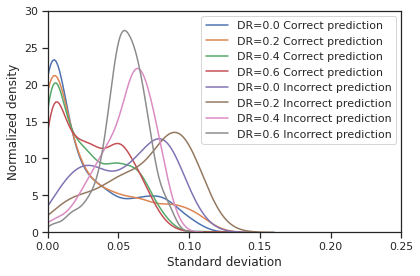

In [38]:
# Check the correct and incorrect mean/std

def dist(mean):
    return np.abs(mean-0.5)

def check_target(file, target):
    print ('plotting %s...' % target)
    df = pd.read_csv(file)
    name = file.split('_')[2]
    plot_dict = {}
    for dr in [0, 0.2, 0.4, 0.6]:
        incorrect = []
        correct = []
        plot_dict[dr] = {'Correct':[], 'Incorrect':[]}
        for i in df.index:
            pred = df['%s_%s' % (dr, target)][i]
            if target == 'mean':
                pred = dist(pred)
            pred_mean = df['%s_mean' % dr][i]
            if int(pred_mean/0.5) == int(df['true label'][i]):
                plot_dict[dr]['Correct'].append(pred)
            else:
                plot_dict[dr]['Incorrect'].append(pred)

    sns.set_style("white")
    sns.set_style("ticks", {"xtick.major.size": 1, "ytick.major.size": 1})

    for c in ['Correct', 'Incorrect']:
        for dr in plot_dict.keys():
            data = plot_dict[dr][c]
            sns.kdeplot(data, label = 'DR=%.1f %s prediction' % (dr, c))
    if target == 'mean':
        plt.xlim(0, 1)
        plt.ylim(0, 20)
        plt.xticks([x/5 for x in range(6)])
        plt.xlabel('Distance(mean, 0.5)')
    else:
        plt.xlim(0, 0.2)
        plt.ylim(0, 30)
        plt.xticks([x/20 for x in range(6)])
        plt.xlabel('Standard deviation')
    plt.legend(loc = 1)
    plt.ylabel('Normalized density')
    plt.tight_layout()
    plt.show()
    # plt.savefig('Plot/new_%s_%s_%s.jpg' % (name, target, dr2))
    plt.close()
    return

file = 'CYP_1a2_y_mc.csv'
check_target(file, 'mean')
check_target(file, 'std')

Excluding uncertain prediction by mean...


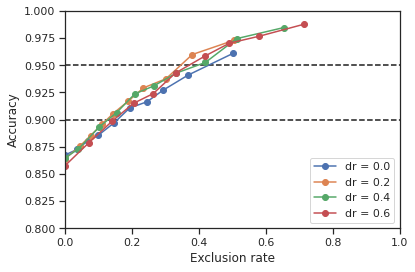

Excluding uncertain prediction by std...


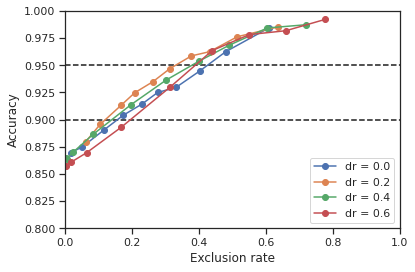

Excluding uncertain prediction by CI...


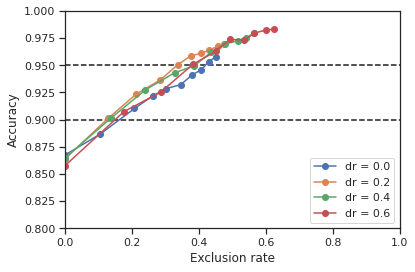

In [40]:
# Plot the accuracy from excluding uncertain predictions by different criteria

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

def dist(mean):
    return np.abs(mean-0.5)

def test_acc(df, column, criteria = 'std'):
    exclude_rates = []
    accuracies = []
    if criteria == 'std':
        cl = [0.1-0.01*x for x in range(10)]
    if criteria == 'mean':
        cl = [0.05*x for x in range(10)]
    if criteria == 'CI':
        cl = [2*x for x in range(10)] 
    

    for cutoff in cl:
        try:
            y_mean = df[column]
            y_std = df[column.replace("mean", "std")]  
            y_pred = []
            index = []
            for i in range(len(y_mean)):
                if criteria == 'std' and y_std[i] < cutoff:
                    y_pred.append(y_mean[i])
                    index.append(i)
                elif criteria == 'mean' and np.abs(y_mean[i]-0.5) > cutoff:
                    y_pred.append(y_mean[i])
                    index.append(i)  
                elif criteria == 'CI':
                    if y_mean[i] - cutoff * y_std[i] > 0.5 or y_mean[i] + cutoff * y_std[i] < 0.5:
                        y_pred.append(y_mean[i])
                        index.append(i)            
            y_pred = np.array(y_pred)
            auc = roc_auc_score(df['true label'][index], y_pred)
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            acc = accuracy_score(df['true label'][index], y_pred)
            tn, fp, fn, tp = confusion_matrix(df['true label'][index], y_pred).ravel()
            SE = tp/(tp+fn)
            SP = tn/(fp+tn)
            PP = tp/(tp+fp)
            NP = tn/(fn+tn) 
            exclude_rate = (len(df['true label']) - len(index))/len(df['true label'])
    #            print ('Criteria: %.2f, Acc: %.3f, AUC: %.3f, SP: %.3f, SE: %.3f, NP: %.3f, PP: %.3f, Exclude rataio %.3f' % 
    #                            (criteria, acc, auc, SP, SE, NP, PP, exclude_rate))
            exclude_rates.append(exclude_rate)
            accuracies.append(acc)
            
        except:
            print ('Criteria: %s and Cutoff: %.2f get no data' % (criteria, cutoff))
            
    return exclude_rates, accuracies



def exclude_by(file, criteria):
    print ('Excluding uncertain prediction by %s...' % criteria)
    results = {}
    name = file.split('_')[-2]
    df = pd.read_csv(file)
    ax = plt.subplot()  
    for dr in [0, 0.2, 0.4, 0.6]:
        column = '%s_mean' % (dr)
        exclude_rates, accuracies = test_acc(df, column, criteria)
        ax.plot(exclude_rates, accuracies, '-o', label = 'dr = %.1f' % dr)
    plt.ylim([0.8, 1])
    plt.xlim([0, 1])
    plt.hlines(0.9, 0, 1, linestyles='dashed')
    plt.hlines(0.95, 0, 1, linestyles='dashed')
    plt.ylabel('Accuracy')
    plt.xlabel('Exclusion rate')
    plt.legend(loc = 4)
    plt.show()
    # plt.savefig('2c19/%s_dr1=%s.jpg' % (criteria, dr1), dpi = 300)
    plt.close()
    return

file = 'CYP_1a2_y_mc.csv'
exclude_by(file, 'mean')
exclude_by(file, 'std')
exclude_by(file, 'CI')